In [1]:
import os
import yaml
from glob import glob
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.utils import image_dataset_from_directory
from tensorflow import data as tf_data
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# read configuration file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

2025-08-17 09:29:16.740644: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-17 09:29:16.753555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755440956.769514 1771509 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755440956.774630 1771509 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755440956.786785 1771509 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
image_size = (41, 41)

train_ds, val_ds = image_dataset_from_directory(
    directory=os.path.join(config['data_dir'], 'train'),
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=32,
    image_size=image_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both',
    interpolation='bilinear',
    verbose=True
)

Found 179904 files belonging to 2 classes.
Using 143924 files for training.
Using 35980 files for validation.


I0000 00:00:1755440967.388019 1771509 gpu_device.cc:2410] Ignoring visible gpu device (device: 2, name: NVIDIA T400 4GB, pci bus id: 0000:e3:00.0, compute capability: 7.5) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
I0000 00:00:1755440967.599067 1771509 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 857 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:31:00.0, compute capability: 8.9
I0000 00:00:1755440967.603714 1771509 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46122 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:b1:00.0, compute capability: 8.9


In [3]:
# Print the class names to see what 0 and 1 correspond to
print("Class names:", train_ds.class_names)
print("0 =", train_ds.class_names[0])
print("1 =", train_ds.class_names[1])

Class names: ['0_nonlens', '1_lens']
0 = 0_nonlens
1 = 1_lens


2025-08-17 09:29:28.747226: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


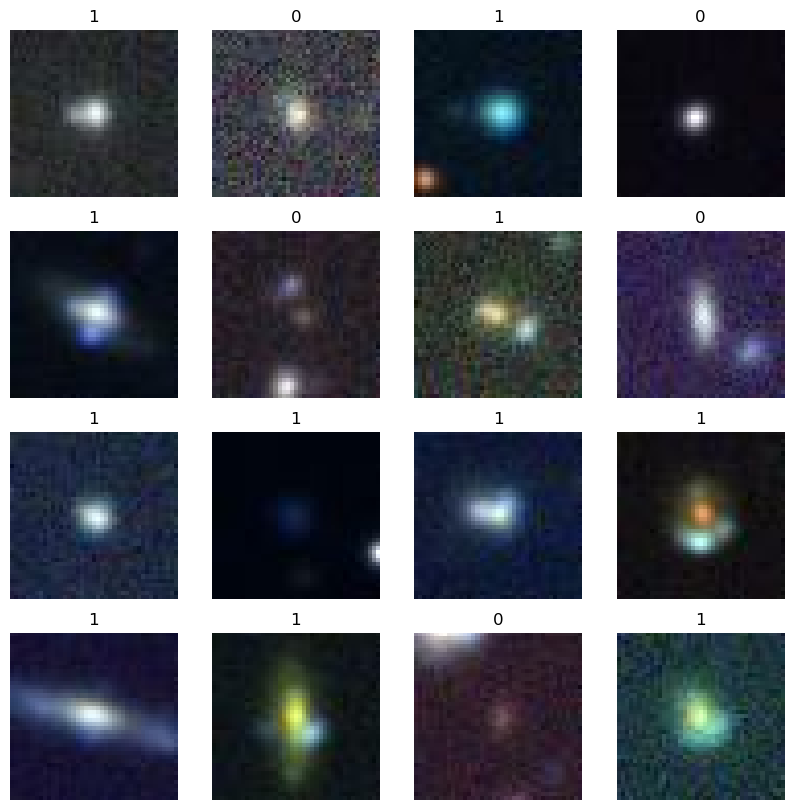

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

In [6]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

In [8]:
epochs = 25

callbacks = [
    # keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


I0000 00:00:1755440973.642066 1771777 service.cc:152] XLA service 0x7f0128009580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755440973.642092 1771777 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1755440973.642097 1771777 service.cc:160]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-08-17 09:29:33.784382: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755440974.507260 1771777 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-08-17 09:29:35.213310: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 872.42MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if

  37/4498 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - acc: 0.6690 - loss: 0.6005 

I0000 00:00:1755440979.322738 1771777 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4488/4498 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8900 - loss: 0.2481

2025-08-17 09:29:57.722254: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 858.92MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-17 09:29:57.813618: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-17 09:29:57.890776: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-17 09:29:57.901824: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.19GiB with freed_by_count=0. The caller indicates that this is 

4498/4498 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8900 - loss: 0.2479

2025-08-17 09:30:10.706221: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-17 09:30:10.788887: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-17 09:30:10.946205: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-17 09:30:11.026595: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-17 09:30:11.109782: E external/local_xla/xla/stream_

4498/4498 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - acc: 0.8900 - loss: 0.2479 - val_acc: 0.9443 - val_loss: 0.1375
Epoch 2/25
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - acc: 0.9437 - loss: 0.1363 - val_acc: 0.9399 - val_loss: 0.1356
Epoch 3/25
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - acc: 0.9536 - loss: 0.1128 - val_acc: 0.9528 - val_loss: 0.1217
Epoch 4/25
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - acc: 0.9609 - loss: 0.0971 - val_acc: 0.9599 - val_loss: 0.0926
Epoch 5/25
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - acc: 0.9642 - loss: 0.0879 - val_acc: 0.9630 - val_loss: 0.0849
Epoch 6/25
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - acc: 0.9673 - loss: 0.0817 - val_acc: 0.9651 - val_loss: 0.0904
Epoch 7/25
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - acc: 0.9700 - loss: 0.0749 - val_acc: 0.9702 - val_loss: 0.0856
Epoch 8/25
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - acc: 0.9729 - loss: 0.0693 - val_acc: 0.9718 - val_loss: 0.0732
Epoch 9/25
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 2

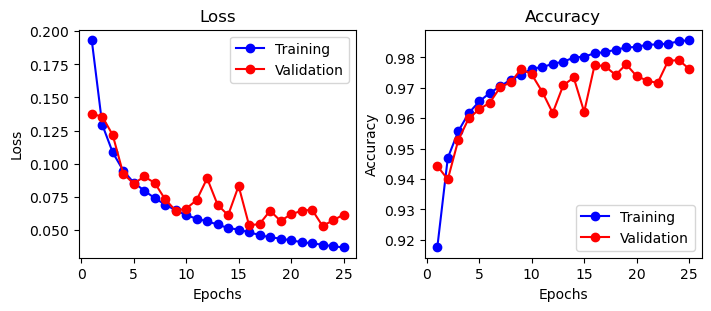

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

_, ax = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
epoch_list = range(1, len(loss) + 1)

ax[0].plot(epoch_list, loss, 'bo-', label='Training')
ax[0].plot(epoch_list, val_loss, 'ro-', label='Validation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim(0, 1)
ax[0].legend()

ax[1].plot(epoch_list, accuracy, 'bo-', label='Training')
ax[1].plot(epoch_list, val_accuracy, 'ro-', label='Validation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
# ax[1].set_ylim(0, 1)
ax[1].legend()

plt.show()

In [10]:
test_ds = image_dataset_from_directory(
    directory=os.path.join(config['data_dir'], 'test'),
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=32,
    image_size=image_size,
    shuffle=True,
    interpolation='bilinear',
    verbose=True
)

Found 19999 files belonging to 2 classes.


In [11]:
score = model.evaluate(test_ds, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2025-08-17 09:39:53.053663: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 871.30MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-17 09:39:53.147287: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-17 09:39:53.224805: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-17 09:39:53.235162: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.20GiB with freed_by_count=0. The caller indicates that this is 

Test loss: 0.0628962591290474
Test accuracy: 0.9771988391876221


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


2025-08-17 09:39:54.845124: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


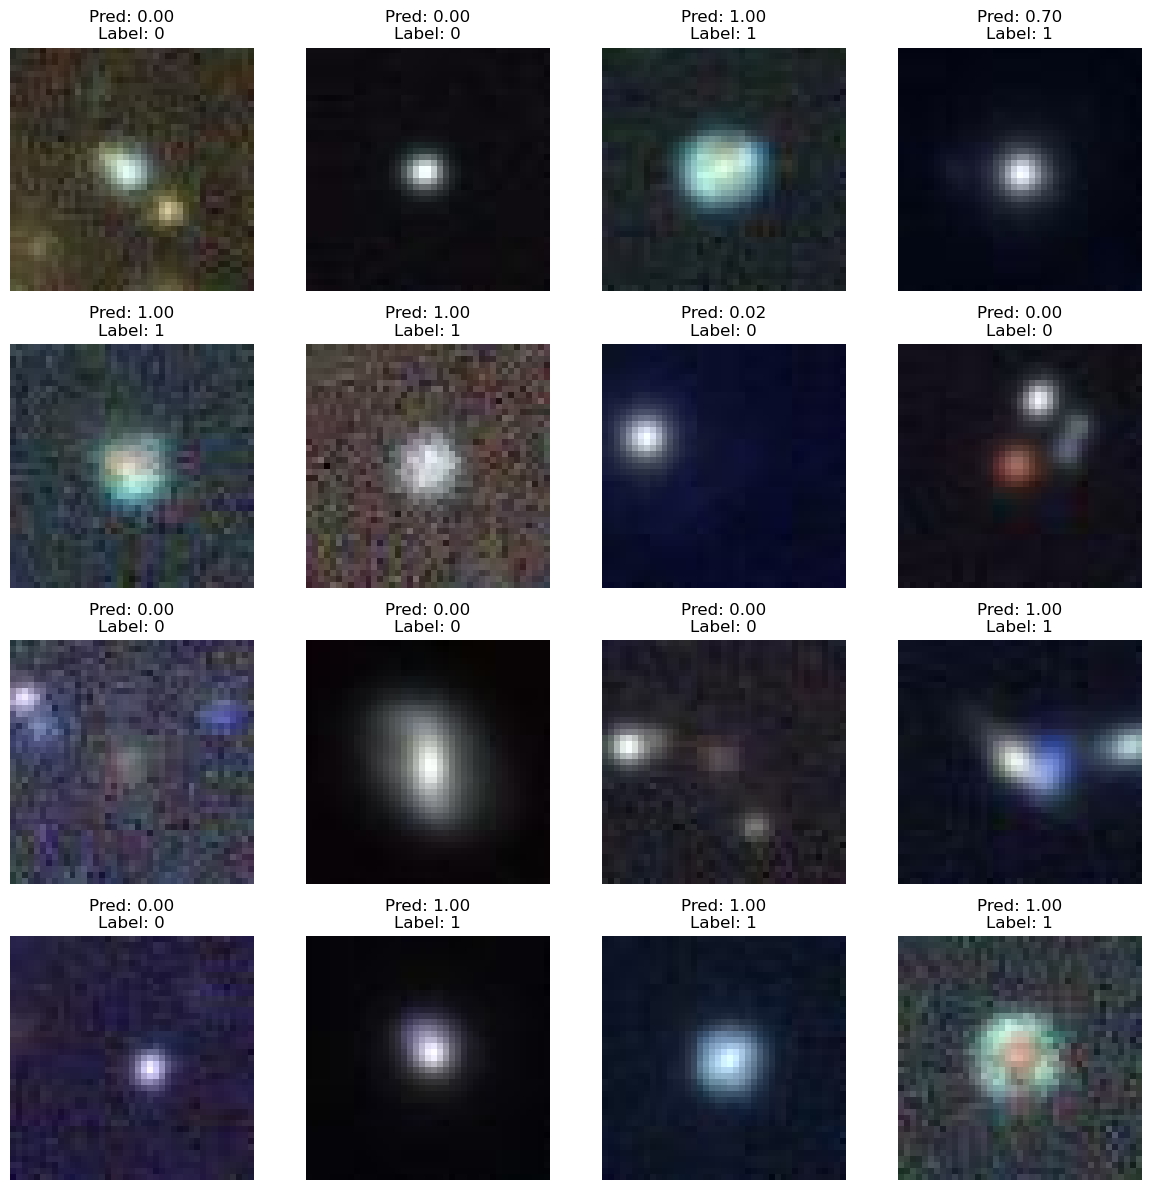

In [12]:
plt.figure(figsize=(12, 12))
for idx, (images_batch, labels_batch) in enumerate(test_ds.take(1)):
    preds = model.predict(images_batch)
    probs = keras.ops.sigmoid(preds).numpy().flatten()
    for i in range(min(16, images_batch.shape[0])):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(f"Pred: {probs[i]:.2f}\nLabel: {int(labels_batch[i].numpy()[0])}")
        plt.axis("off")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

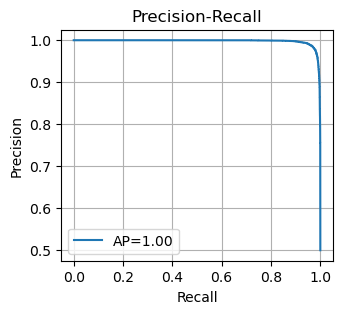

In [13]:
# Collect predictions and true labels from test_ds
y_true = []
y_scores = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch)
    probs = keras.ops.sigmoid(preds).numpy().flatten()  # Use sigmoid to get probabilities
    y_scores.extend(probs)
    y_true.extend(labels_batch.numpy().flatten())

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure(figsize=(3.5, 3))
plt.plot(recall, precision, label=f'AP={ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

2025-08-17 09:41:29.048560: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


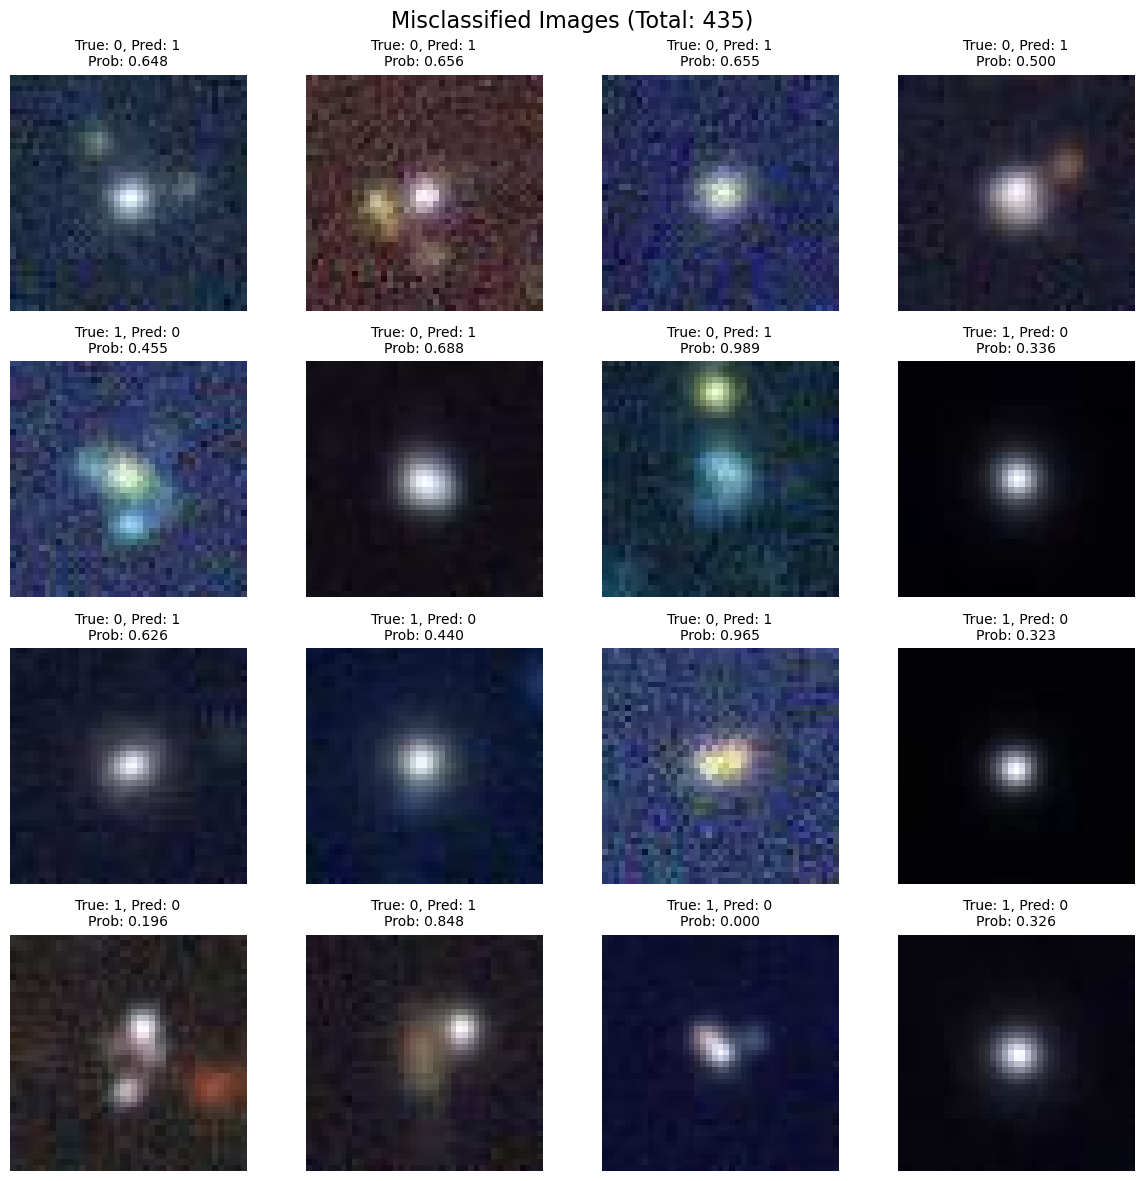

Total misclassified images: 435


In [14]:
# Collect misclassified images
misclassified_images = []
misclassified_labels = []
misclassified_probs = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch)
    probs = keras.ops.sigmoid(preds).numpy().flatten()
    
    # Convert probabilities to binary predictions (threshold at 0.5)
    pred_labels = (probs > 0.5).astype(int)
    true_labels = labels_batch.numpy().flatten().astype(int)
    
    # Find misclassified samples
    misclassified_mask = pred_labels != true_labels
    
    if np.any(misclassified_mask):
        misclassified_images.extend(images_batch[misclassified_mask].numpy())
        misclassified_labels.extend(true_labels[misclassified_mask])
        misclassified_probs.extend(probs[misclassified_mask])

# Display misclassified images
num_to_show = min(16, len(misclassified_images))
if num_to_show > 0:
    plt.figure(figsize=(12, 12))
    for i in range(num_to_show):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(misclassified_images[i].astype("uint8"))
        true_label = misclassified_labels[i]
        pred_prob = misclassified_probs[i]
        pred_label = 1 if pred_prob > 0.5 else 0
        plt.title(f"True: {true_label}, Pred: {pred_label}\nProb: {pred_prob:.3f}", fontsize=10)
        plt.axis("off")
    plt.suptitle(f"Misclassified Images (Total: {len(misclassified_images)})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"Total misclassified images: {len(misclassified_images)}")
else:
    print("No misclassified images found!")